In [1]:
%load_ext autoreload
%autoreload 2

# Dataset explanation

For our project, we've selected a dataset constructed from internal email exchanges within a large European research institution. The dataset captures anonymized records of all emails sent between members of the institution. In the corresponding network, an edge
$(u,v)$ exists whenever person $u$ sent at least one email to person $v$. Because the data only includes communication among institutional members, it represents a closed network without any external incoming or outgoing messages.

An important feature of this dataset is the availability of “ground-truth” community labels. Each individual belongs to exactly one of the institution’s 42 departments, providing predefined community memberships that can be used to evaluate our community detection methods.

The dataset can be accessed from the following link (https://snap.stanford.edu/data/email-Eu-core.html), or downloaded and put inside the correct folder by executing the following cell.



In [4]:
from utils import download_data

files = [
    "email-Eu-core.txt.gz",
    "email-Eu-core-department-labels.txt.gz"
]

download_data('twitch', "https://github.com/Carda01/community_detection/releases/download/1.0/", ['twitch_data.zip'], category='twitch')
download_data('email', "https://snap.stanford.edu/data/", files, category='email')

Extracting PTBR files from twitch_data.zip...
Extracting twitch_data/musae_PTBR_target.csv...
Extracting twitch_data/musae_PTBR_edges.csv...
Twitch PTBR files downloaded and extracted successfully.
Extracting email-Eu-core.txt.gz...
Saved extracted file to data/email/email-Eu-core.txt

Extracting email-Eu-core-department-labels.txt.gz...
Saved extracted file to data/email/email-Eu-core-department-labels.txt

Email core files downloaded and extracted successfully.


# Preliminary analysis

For the following preliminary analysis we made the graph undirected, so as long as there is an edge between u and v (no matter the direction), in the newly built undirected graph there will be an edge between u and v. Also we've removed from the graph those nodes which have just self loops and no other edges to other nodes.


In [5]:
from utils import *

G = load_email()
show_mail_graph(G, k_core=5)

Calculating and adding node attribute 'degree'...


alt.LayerChart(...)

### Spy Plot

The sparsity plot (spyplot) of the adjacency matrix with the nodes ordered by their department is a sanity check.

If we get diagonal blocks it means that people inside their department sends each other a lot of mails, while they tend to send few to people of other departments.
And this is actually what we get. At the same time, there are some people (from departments 32-37 and especially department 36) who sends email to all the people. Our hypothesis is that they are the
managers or system admin department. We can already predict that it will be hard for these departments to separate them into their respective communities.
Additionally, we can notice that the communities vary drastically in size, and some are very small, like the 18th or the 12th.

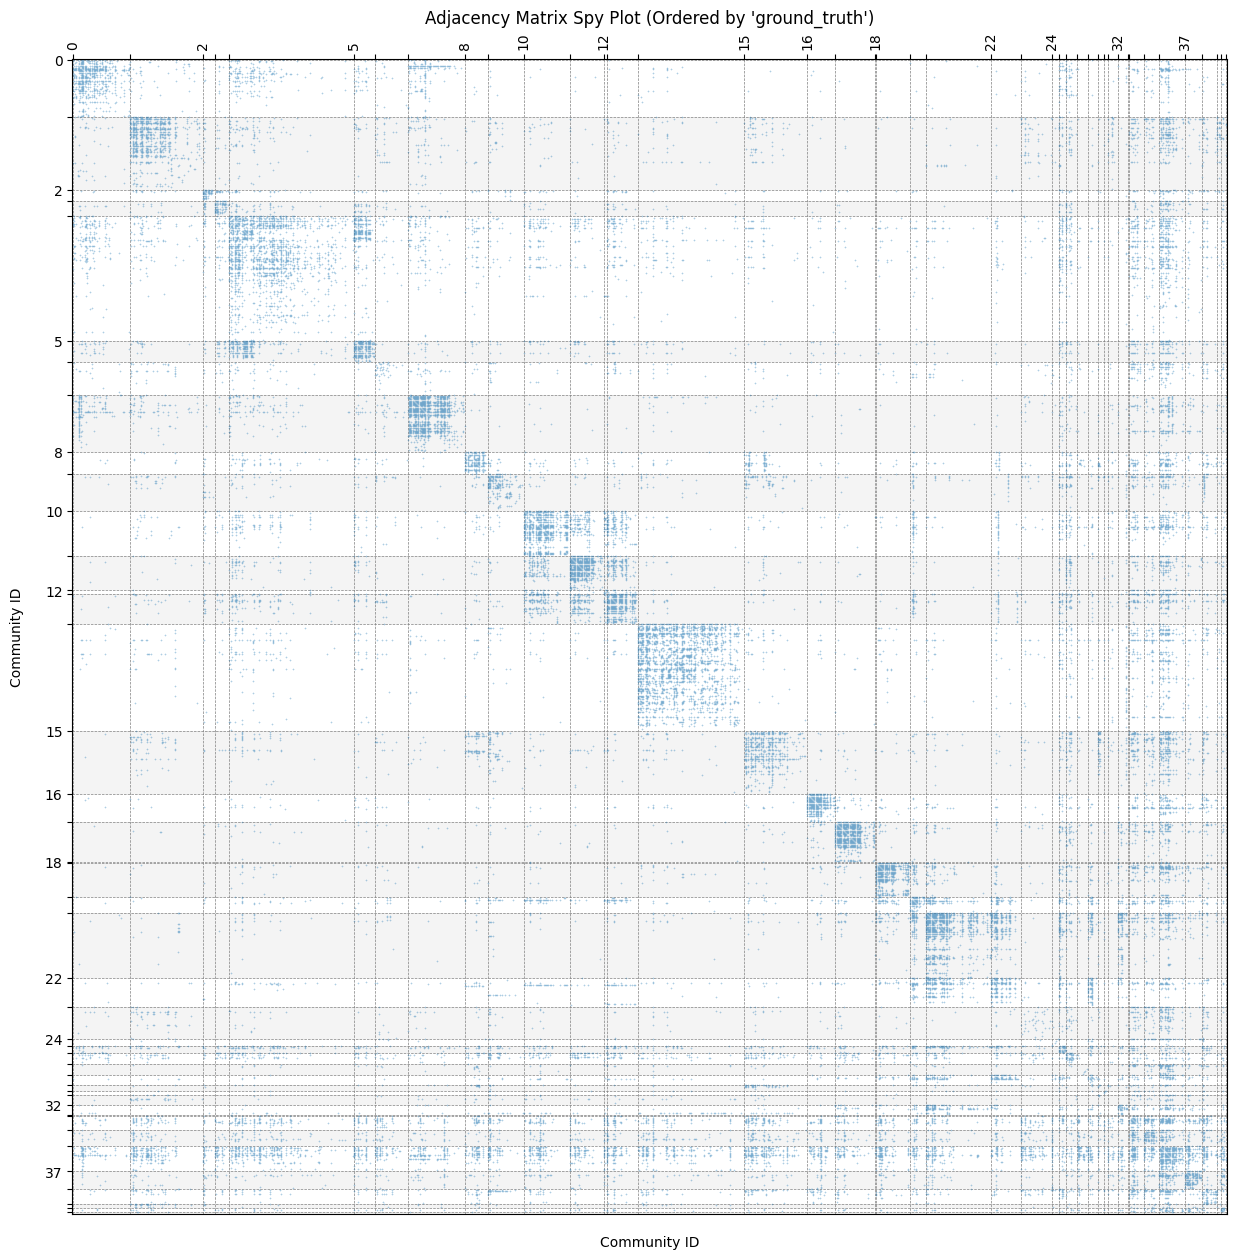

In [4]:
from utils import *

spy_plot_adjacency(G)

### General statistics
From the values of the diameter and the avg shortest path length, we can say that the network exhibits the classic "small-world" property. The degree distribution is
heavily right-skewed. It also indicates the presence of few highly connected nodes (hubs) whose degrees extend towards 350. The network's communication flow is largely
driven by these hubs (likely managers, system admins, or highly collaborative individuals), while the majority of nodes have lower connectivity.

The Clique Size (k) Distribution plot shows a roughly normal (bell-shaped) distribution centered around $k \approx 9$ to 10. This suggests a strong, consistent tendency
for nodes to organize into tightly connected, medium-sized groups (cliques). This is a strong indicator of robust community structure. Also, this can be noticed by the
high value of the clustering coefficient. In a random graph it is rougly equal to the density, but here we have $0.4 \gg 0.03$.


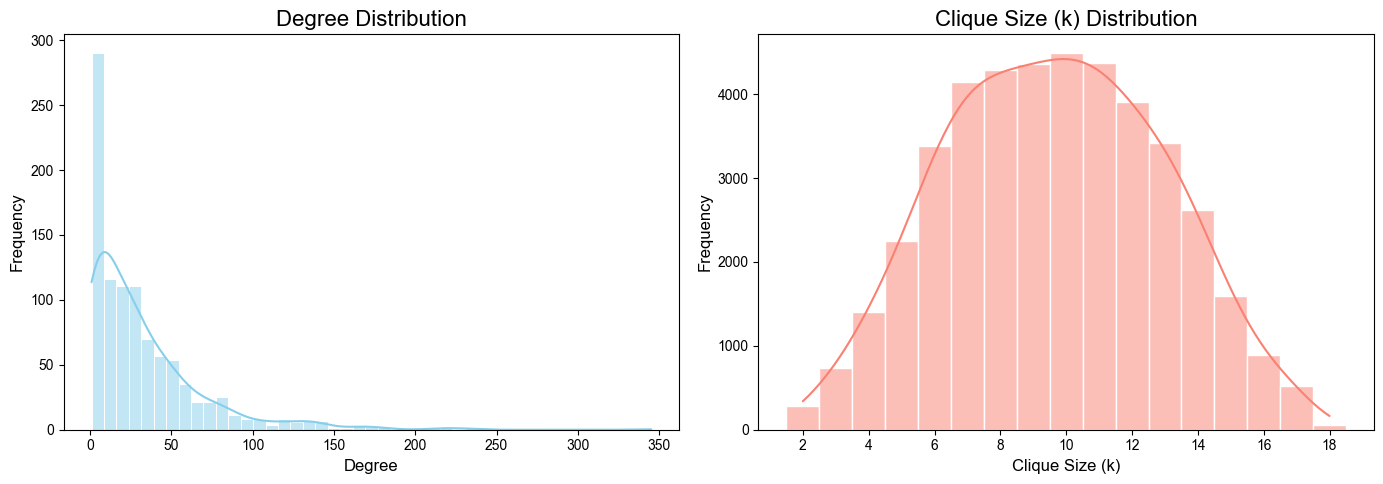

Number of nodes: 986
Number of edges: 16064
Average degree: 32.58
Density: 0.0331
Average clustering coefficient: 0.4071
Graph is connected.
Radius: 4
Diameter: 7
Average shortest path length: 2.59


In [5]:
hist_degrees_cliques(G)
summary_stats(G)

### Centrality Measures
bla bla bla fill this


In [6]:
import networkx as nx
from utils import *

centralities = calculate_centrality_metrics(G, [nx.pagerank, nx.betweenness_centrality, nx.closeness_centrality, nx.laplacian_centrality, nx.eigenvector_centrality])

Calculating and adding node attribute 'pagerank'...
Calculating and adding node attribute 'betweenness_centrality'...
Calculating and adding node attribute 'closeness_centrality'...
Calculating and adding node attribute 'laplacian_centrality'...
Calculating and adding node attribute 'eigenvector_centrality'...


In [7]:
show_top_nodes_by_centrality(centralities, 'betweenness_centrality')

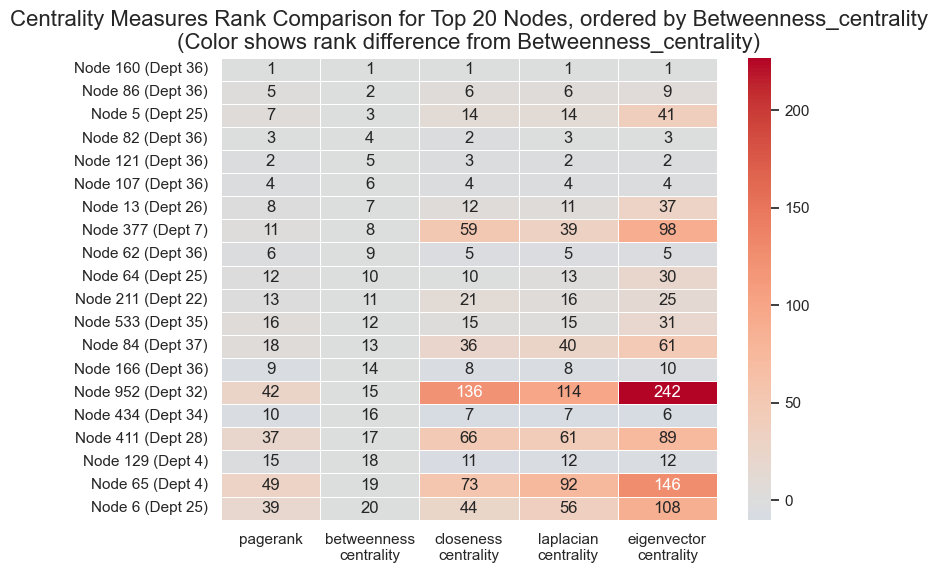

In [8]:
visualize_top_n_centrality(centralities, 'betweenness_centrality')

In [9]:
generic_show(G, node_color='betweenness_centrality',
             node_size='pagerank',
             node_tooltip=['ground_truth', 'degree', 'pagerank', 'betweenness_centrality'],
             k_core=20,
             layout_func=nx.spiral_layout)

alt.LayerChart(...)

# Community detection
bla bla bla fill this


# Influence Maximization
We consider a scenario in which the EU research institution aims to identify internal security vulnerabilities. If a malicious actor compromises a single user's email account, they can leverage established organizational trust to propagate malicious content to colleagues in a cascading attack. Consequently, our objective is to identify the users who represent the highest risk, specifically, those whose compromise would result in the widest dissemination of the threat. Formally, this is an Influence Maximization problem, where we aim to identify the optimal seed set S that maximizes the spread of influence across the network

In [10]:
G = load_email(directed=True)

In [11]:
import networkx as nx
import numpy as np
import random
import time
from tqdm import tqdm  # For progress bars

P_INFLUENCE = 0.05       # Probability (p) that a user infects a colleague
MC_SIMULATIONS = 1000    # Monte Carlo simulations per spread calculation
BUDGET = 3               # Number of users to find (S)

def get_spread(G, seeds, p=0.01, mc=1000):
    """
    Calculates the 'spread' (expected number of infected nodes)
    using Monte Carlo simulations of the Independent Cascade model.
    """
    spread = []

    for _ in range(mc):
        # Active set: initially just the seeds
        new_active, A = seeds[:], seeds[:]

        while new_active:
            # For each newly active node, find its neighbors
            new_ones = []
            for newly_infected_node in new_active:
                # Get neighbors that are NOT already infected
                # We perform a random trial for each neighbor
                neighbors = list(G.successors(newly_infected_node))

                # Vectorized random choice for speed (faster than loop)
                if not neighbors:
                    continue

                # Determine which neighbors get infected (probability > random_val)
                success = np.random.random(len(neighbors)) < p
                successful_neighbors = np.array(neighbors)[success]

                # Filter out those already in A
                for n in successful_neighbors:
                    if n not in A:
                        new_ones.append(n)
                        A.append(n)

            new_active = new_ones

        spread.append(len(A))

    return np.mean(spread)

# ---------------------------------------------------------
# 3. CELF Algorithm (Optimized Greedy)
# ---------------------------------------------------------
def celf(G, k, p=0.01, mc=1000):
    """
    Finds k seed nodes using the Cost-Effective Lazy Forward algorithm.
    """
    start_time = time.time()
    print(f"\n[Starting CELF] Target seeds: {k} | Simulations: {mc} | p: {p}")

    # --- Step 1: First Iteration (Standard Greedy) ---
    # Calculate marginal gain for ALL nodes
    margins = []
    nodes = list(G.nodes())

    print("  > Round 1: Calculating initial spread for all nodes...")
    for node in tqdm(nodes):
        marginal_gain = get_spread(G, [node], p, mc)
        margins.append([node, marginal_gain])

    # Sort by spread (descending)
    margins.sort(key=lambda x: x[1], reverse=True)

    # Select the first node (best individual spread)
    S = [margins[0][0]]
    spread = margins[0][1]
    timelapse = [time.time() - start_time]

    print(f"  > Seed 1 found: Node {S[0]} (Spread: {spread:.2f})")

    # Remove the selected node from the list and re-sort logic prep
    margins = margins[1:]

    # --- Step 2: CELF Loop ---
    while len(S) < k:
        matched = False

        while not matched:
            # Grab the current top candidate
            current_node, old_gain = margins[0]

            # Calculate the ACTUAL marginal gain of adding this node to S
            # Spread(S + node) - Spread(S)
            new_spread = get_spread(G, S + [current_node], p, mc)
            new_gain = new_spread - spread

            # Update the gain in the list
            margins[0] = [current_node, new_gain]

            # Re-sort the list to see if it stays on top
            # (In CELF, we usually just re-insert it in sorted order,
            # but Python's sort is Timsort (efficient for mostly sorted data))
            margins.sort(key=lambda x: x[1], reverse=True)

            # Check if the top node is still the same node we just calculated
            if margins[0][0] == current_node:
                matched = True
                S.append(current_node)
                spread = new_spread
                timelapse.append(time.time() - start_time)
                print(f"  > Seed {len(S)} found: Node {current_node} (Marginal Gain: {new_gain:.2f})")

    return S, spread, timelapse

# ---------------------------------------------------------
# 4. Execution
# ---------------------------------------------------------
seeds, final_spread, times = celf(G, k=BUDGET, p=P_INFLUENCE, mc=MC_SIMULATIONS)

print("-" * 50)
print(f"Optimal Seed Set S: {seeds}")
print(f"Estimated Total Spread: {final_spread:.2f} users")
print(f"Computation Time: {times[-1]:.2f} seconds")
print("-" * 50)


[Starting CELF] Target seeds: 3 | Simulations: 1000 | p: 0.05
  > Round 1: Calculating initial spread for all nodes...


100%|██████████| 986/986 [16:51<00:00,  1.03s/it]


  > Seed 1 found: Node 13 (Spread: 466.11)


KeyboardInterrupt: 